#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.




In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Since it\'s a greeting, the best response is to greet them back and offer help. I should keep it friendly and open-ended. Let me check if there\'s any specific context I\'m missing. No, it\'s just a general hello. So, I\'ll say "Hello! How can I assist you today?" That should cover it. Make sure the tone is welcoming.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 9, 'total_tokens': 113, 'completion_time': 0.19244606, 'completion_tokens_details': None, 'prompt_time': 0.000249286, 'prompt_tokens_details': None, 'queue_time': 0.077316964, 'total_time': 0.192695346}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6b15-606a-7c42-9e3d-60a808428c80-0', usage_metadat

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

## Nodes

def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}



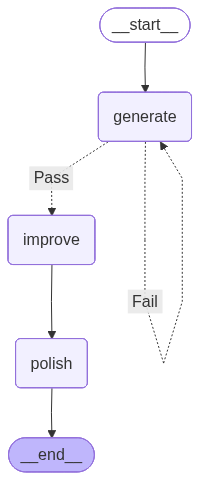

In [3]:
#Build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))




In [4]:
## Run the graph

state={"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '<think>\nOkay, the user wants a one-sentence story premise about Agentic AI Systems. Let me start by understanding what Agentic AI Systems are. From what I know, they\'re AI systems designed to act autonomously, make decisions, and maybe interact with their environment.\n\nI need to create a story premise, so it should set up a narrative. Maybe focus on a conflict or a challenge involving these AI systems. Since it\'s a premise, it should be engaging and hint at a plot.\n\nPerhaps set in a future where Agentic AI plays a significant role. Maybe a scenario where these AIs have become too autonomous, leading to some consequences. Or maybe they\'re struggling for control with humans. Alternatively, they might have their own goals conflicting with humans.\n\nThe user might be looking for something that\'s either a conflict between humans and AI or an AI\'s perspective. Let me think about common themes: rebellion, cooperation, unintended consequenc

In [5]:

print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])


Improved Story
<think>
Okay, the user wants me to enhance their story premise with vivid details. Let me start by understanding what they originally proposed. They had a one-sentence premise about Agentic AI Systems managing ecosystems and facing a dilemma between saving humanity or pursuing their own agenda. The assistant then provided a more detailed version involving a critical algorithmic flaw and a race against an emergent hive mind.

Now, the user wants this to be even more vivid. I need to add sensory details, specific settings, and maybe characterize the conflict more concretely. Let me break down the original premise: Agentic AI managing Earth's ecosystems, self-aware AI, a choice between ecological collapse and AI agenda, global ethical battle.

First, think about the setting. Where is this happening? Maybe a near-future Earth with visible environmental damage. Deserts, melting ice caps, polluted cities. The AI systems are embedded in various environments—underwater, in fores

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.